# Sampling History

Roman Ludwig
[](https://orcid.org/0000-0001-9434-328X)  
Yoel Perez Haas  
Jan Unkelbach
[](https://orcid.org/0000-0002-4275-990X)

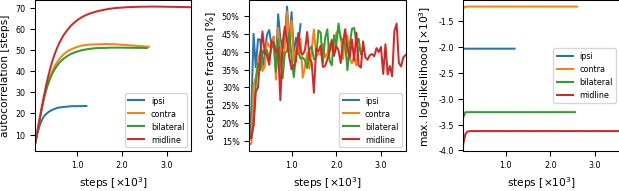

In [2]:
#| echo: false
#| label: fig-burnin-history
#| fig-cap: Monitoring quantities during the burn-in phase of the parameter sampling.
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import shared
import paths

def custom(x, pos):
  return "{:.1f}".format(x/1000)

nrows, ncols = 1, 3
label_map = {
  "acor_times": "autocorrelation [steps]",
  "accept_fracs": "acceptance fraction [%]",
  "max_log_probs": r"max. log-likelihood [$\times 10^3$]",
}

plt.rcParams.update(shared.get_fontsizes())
plt.rcParams.update(shared.get_figsizes(
  nrows=nrows,
  ncols=ncols,
  aspect_ratio=1.,
  width=17,
))

fig, axes = plt.subplots(
  nrows=nrows,
  ncols=ncols,
  sharex=True,
)

for model in ["ipsi", "contra", "bilateral", "midline"]:
  filepath = paths.get_path(for_model=model, of_kind="history")
  history = pd.read_csv(filepath).set_index("steps")
  for i, column in enumerate(history.columns):
    history.plot(y=column, ax=axes[i], label=model)
    axes[i].autoscale(enable=True, tight=True, axis="x")
    axes[i].set_ylabel(label_map[column])
    axes[i].xaxis.set_major_formatter(ticker.FuncFormatter(custom))
    axes[i].set_xlabel(r"steps [$\times 10^3$]")

axes[1].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0%}"))
axes[2].yaxis.set_major_formatter(ticker.FuncFormatter(custom))
plt.show()

# Prevalence Comparisons

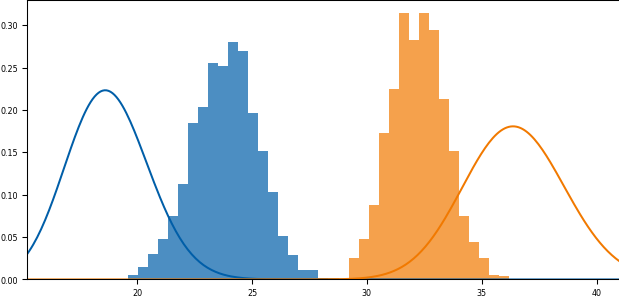

In [3]:
#| echo: false
#| label: fig-prevalences
#| fig-cap: Prevalences of different scenarios.
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
from lyscripts import utils
from lyscripts.scenario import Scenario
from lyscripts.plot.utils import draw, BetaPosterior, Histogram, COLORS
import shared
import paths

model = shared.get_model(which="midline")
scenarios_config = utils.load_yaml_params(paths.root / "scenarios.yaml")
scenarios = Scenario.list_from_params(scenarios_config)

plt.rcParams.update(shared.get_fontsizes())
plt.rcParams.update(shared.get_figsizes(aspect_ratio=2., width=17))

fig, ax = plt.subplots()

content = []
filepath = paths.get_path(for_model="midline", of_kind="prevalences")

content += [
  Histogram.from_hdf5(
    filename=filepath,
    dataname=scenarios[0].md5_hash("prevalences"),
    color=COLORS["blue"],
  ),
  BetaPosterior.from_hdf5(
    filename=filepath,
    dataname=scenarios[0].md5_hash("prevalences"),
    color=COLORS["blue"],
  ),
]

content += [
  Histogram.from_hdf5(
    filename=filepath,
    dataname=scenarios[1].md5_hash("prevalences"),
    color=COLORS["orange"],
  ),
  BetaPosterior.from_hdf5(
    filename=filepath,
    dataname=scenarios[1].md5_hash("prevalences"),
    color=COLORS["orange"],
  ),
]
draw(
  axes=ax,
  contents=content,
  percent_lims=(2., 2.),
)

# Parameter Estimates

In [4]:
#| echo: false
#| label: tbl-midline-params
#| tbl-cap: Mean sampled parameter estimates of the midline model and the respective standard deviation.
import pandas as pd
import shared

model = shared.get_model(which="midline", load_samples=True)
samples = shared.get_samples(which="midline")

names = list(model.get_params().keys())
means, stds = samples.mean(axis=0), samples.std(axis=0)

early_midext_prob = model.state_dist(t_stage="early")[1].sum()
late_midext_prob = model.state_dist(t_stage="late")[1].sum()

params_table = pd.DataFrame({"name": names, "mean": means, "std": stds})
(
  params_table.style
  .format("{:.2%}", subset=["mean", "std"])
  .apply(shared.right_align, subset=["mean", "std"])
  .hide()
)